In [1]:
import torch
import tal
import numpy as np

from model.nerf import NLOSNeRF
from model.scene import Scene
from matplotlib import pyplot as plt

In [2]:
sensor_x = 32
sensor_y = 32
scale = 1
t_max = 256
delta_m_meters = 0.05
scene = Scene(sensor_x=sensor_x, sensor_y=sensor_y)

In [3]:
center = np.array([0, 0, 0.5])
model = NLOSNeRF(positional_encoding=True, ignore_albedo=True).to(device="cuda:1")
dict_ = torch.load("./data/models/T-single-oneshot-integrator-nrho-32-b16-finetuned.pth")
model.load_state_dict(dict_["model_state_dict"])
dx = 1 / np.sqrt(2)
dy = 1 / np.sqrt(2)
dz = 1 / np.sqrt(2)
xv = torch.linspace(start=center[0]+(dx/2), end=center[0]-(dx/2), steps=64)
yv = torch.linspace(start=center[1]+(dy/2), end=center[1]-(dy/2), steps=64)
zv = 0.5*torch.ones((64, 64))
X, Y = torch.meshgrid(xv, yv, indexing="ij")
stack_pts = torch.stack((X, Y, zv), axis=-1)
stack_dirs = (torch.pi / 2) * torch.ones((64, 64, 2))
stack_input = torch.cat((stack_pts, stack_dirs), dim=-1)
with torch.no_grad():
    result = model(model.fourier_encoding(stack_input).to(device="cuda:1"))

FileNotFoundError: [Errno 2] No such file or directory: './data/models/T-single-oneshot-integrator-nrho-32-b16-finetuned.pth'

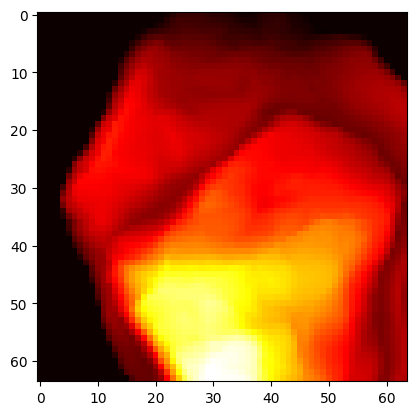

In [11]:
fig, ax = plt.subplots()
pred = torch.prod(result, dim=-1).detach().cpu().numpy()
ax.imshow(pred, cmap="hot")

In [6]:
def get_volume(nx, ny, center):
    """_summary_

    Args:
        nx (_type_): _description_
        ny (_type_): _description_
    """
    dx = 1 / np.sqrt(2)
    dy = 1 / np.sqrt(2)
    dz = 1 / np.sqrt(2)
    xv = np.linspace(start=center[0]-dx/2, stop=center[0]+dx/2, num=nx)
    yv = np.linspace(start=center[1]-dy/2, stop=center[1]+dy/2, num=ny)
    zv = np.linspace(start=center[2]-dz/2, stop=center[2]+dz/2, num=nx)
    X, Y, Z = np.meshgrid(xv, yv, zv)
    return np.stack((X, Y, Z), axis=-1)

In [7]:
path = "./data/Z-scene/Z-scene.hdf5"
gt_data = tal.io.read_capture(path)
tal.reconstruct.compensate_laser_cos_dsqr(gt_data)
gt_H = torch.from_numpy(gt_data.H)
center = np.array([0, 0, 0.5])
volume_xyz = get_volume(64, 64, center=center)

In [3]:
scene.relay_wall()

tensor([[[-0.9688, -0.9688,  0.0000],
         [-0.9688, -0.9062,  0.0000],
         [-0.9688, -0.8438,  0.0000],
         ...,
         [-0.9688,  0.8438,  0.0000],
         [-0.9688,  0.9062,  0.0000],
         [-0.9688,  0.9688,  0.0000]],

        [[-0.9062, -0.9688,  0.0000],
         [-0.9062, -0.9062,  0.0000],
         [-0.9062, -0.8438,  0.0000],
         ...,
         [-0.9062,  0.8438,  0.0000],
         [-0.9062,  0.9062,  0.0000],
         [-0.9062,  0.9688,  0.0000]],

        [[-0.8438, -0.9688,  0.0000],
         [-0.8438, -0.9062,  0.0000],
         [-0.8438, -0.8438,  0.0000],
         ...,
         [-0.8438,  0.8438,  0.0000],
         [-0.8438,  0.9062,  0.0000],
         [-0.8438,  0.9688,  0.0000]],

        ...,

        [[ 0.8438, -0.9688,  0.0000],
         [ 0.8438, -0.9062,  0.0000],
         [ 0.8438, -0.8438,  0.0000],
         ...,
         [ 0.8438,  0.8438,  0.0000],
         [ 0.8438,  0.9062,  0.0000],
         [ 0.8438,  0.9688,  0.0000]],

        [[

In [10]:
gt_data.laser_xyz

array([-0.5 ,  0.  ,  0.25], dtype=float32)

In [72]:
with tal.resources(8):
    rec = tal.reconstruct.fbp.solve(
        data=gt_data,  volume_xyz=volume_xyz, wl_mean=0.2, wl_sigma=0.2
    )

tal.reconstruct.filter_H: Using wavelengths from 0.1325m to 0.4081m
tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [00:00<00:00, 266.18it/s]            


tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3
tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


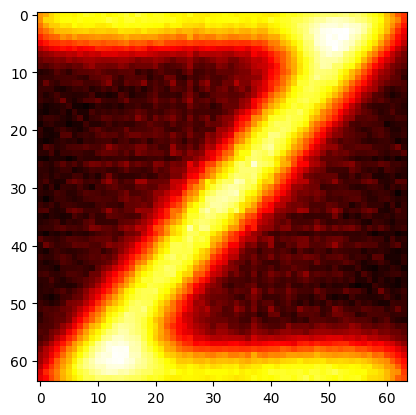

In [73]:
plt.imshow(np.sum(np.abs(rec), axis=-1), cmap="hot")